# TP : Résolution de l'équation de Vlasov-Poisson 1D-1D par une méthode semi-lagrangienne

In [84]:
# Basic imports 
import numpy as np 
import matplotlib.pyplot as plt 
import itertools as it 

On s'intéresse à l'équation de Vlasov  (évolution de la distribution des électrons) couplée avec l'équation de Poisson (évolution du champ électrique) 

\begin{equation}
\begin{cases}
\partial_t f + v \,\partial_x f - E(x,t) \,\partial_v f = 0 \\ 
\\ 
\partial_x E = \rho(x,t) = 1 - \int f(x,v,t) \,dv 
\end{cases}
\end{equation} 


## Discrétisation de l'espace des phases 

On considère un espace des phases périodique en deux dimensions (une d'espace et une de vitesse) $\Omega = [-\pi, \pi]^2 \subset \mathbb{R}^2$ que l'on va discrétiser par une grille uniforme $\mathcal{M} = \{(x_i, v_j)\}_{i= 0\,, \cdots, \,n_x-1\,,\,j=0\,, \cdots,\, n_v-1, }\subset \Omega$ 

In [85]:
nx = 100; nv = 100
dx = 2*np.pi / (2*nx) ; dv =2*np.pi / (2*nv)
dt = 1e-2
x = np.linspace(-np.pi, np.pi, num=nx, dtype=float)
v = np.linspace(-np.pi, np.pi, num=nv, dtype=float)
xx, vv = np.meshgrid(x,v) 

In [86]:
omega = it.product(x,v)
omega = np.array(list(omega), dtype=tuple)

## Condition initiale 

On se donne une condition initiale en distribution de particules $f_0(x,v)$ 

In [87]:
f = lambda x, v : (1 / 2*np.pi)*np.exp(-0.5*(x**2+v**2))


Text(0, 0.5, '$v$')

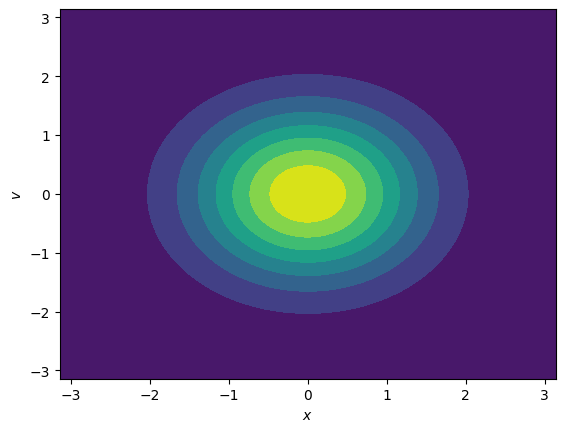

In [88]:
f_zero = f(xx, vv)
plt.contourf(x, v, f_zero)
plt.xlabel(r'$x$')
plt.ylabel(r'$v$')  

On en déduit la densité de charge $\rho_0 (x) = 1 - \int f_0(x,v) \, \text{d}v$ 

In [89]:
rho_zero = np.zeros(nx) 
for i in range(nx): 
    rho_zero[i] = 1 - np.sum(f_zero[i])*dv

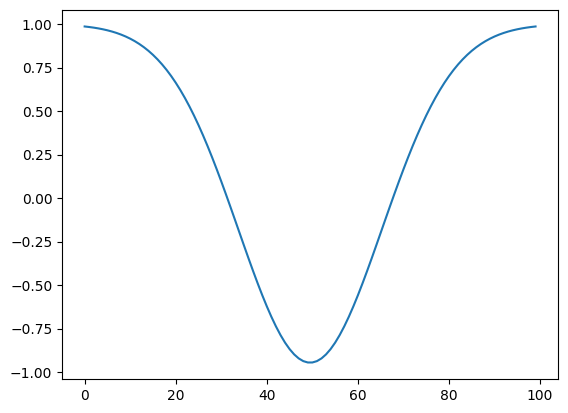

In [90]:
plt.plot(rho_zero)

## Résolution de  l'équation de Poisson

La partie poisson du problème s'écrit 

\begin{equation}
\tag{P}
\partial_x E = \rho(x,t) = 1 - \int f(x, v, t) \,\text{d}v
\end{equation}

On va résoudre ce problème en discrétisant $f$ en modes de Fourier selon 
$$ f^n(x,v) = f(x,v, t_n) = \frac{1}{2\pi} \sum\limits_{k,l} c^n_{k,l} \, e^{i k.x} e^{i l.v} $$
Ainsi 
\begin{align*}
\rho^n(x, v) & = 1 - \frac{1}{2\pi} \sum\limits_{k,l} c^n_{k,l} \, e^{i k.x} \underbrace{\int e^{i l.v} \,\text{d}v}_{=0 \text{ si } l\neq 0 \text{ et } 2\pi \text{ sinon}} \\ 
             & = 1 - \sum\limits_{k} c^n_{k,0} \, e^{i k.x}  \\ 
             & = \sum\limits_{k} \tilde{c_k}^n \, e^{i k.x},         
\end{align*}
en posant $$\tilde{c_k}^n = 
            \begin{cases} 
                1 - c^n_{k,0} & \text { si } k=0 \\
                - c^n_{k,0} & \text{ sinon.}
            \end{cases} 
            $$
On écrit la somme de Fourier pour le champ électrique : 
$$ E^n(x) = \sum\limits_{j} d_j^n \, e^{i j.x} $$ 
donc 
$$ \frac{\text{d} E^n}{\text{d} x} = \sum\limits_{j} i j\, d_j^n \, e^{i j.x} $$

et par identification (unicité) des coefficients de Fourier on obtient $d_k^n = \frac{\tilde{c_k}^n}{ik} \text{ pour } k\neq 0$. La valeur de $d_0^n$ qui correspond à la moyenne du champ électrique peut être choisie librement et on prendra par exemple $d_0^n=0$.

### Calcul des coefficients de Fourier de $f$

In [91]:
c_zero = np.fft.fft2(f_zero)

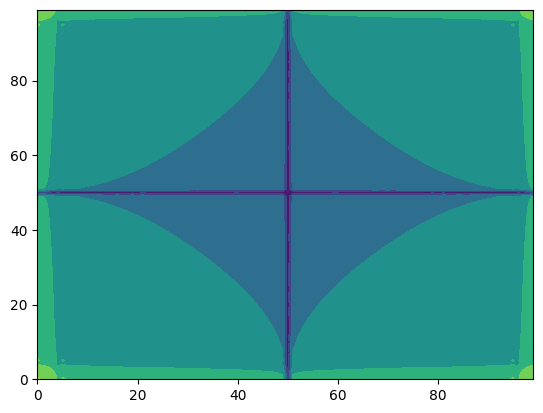

In [92]:
plt.contourf(np.log(np.abs(c_zero)**2))

In [93]:
c_tilde_zero = np.zeros(nx, dtype=complex)
c_tilde_zero[0] = 1 - c_zero[0, 0]
for i in range(1, nx):
    c_tilde_zero[i] = - c_zero[i, 0] 

In [94]:
d_zero = np.zeros(nx, dtype=complex)
d_zero[0] = 0 
for k in range(1,nx):  
    d_zero[k] = (c_tilde_zero[k]) / (k*1j)

In [95]:
_E_zero = np.fft.ifft(d_zero)

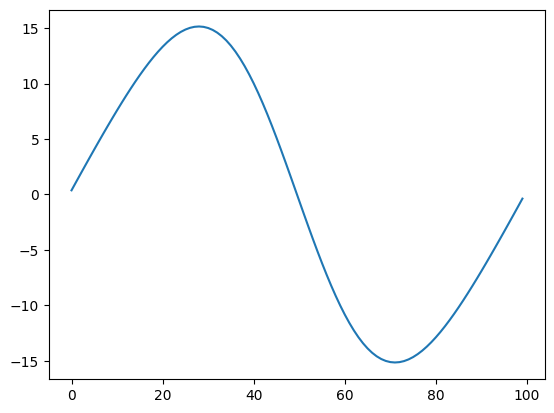

In [96]:
plt.plot(np.real(_E_zero))

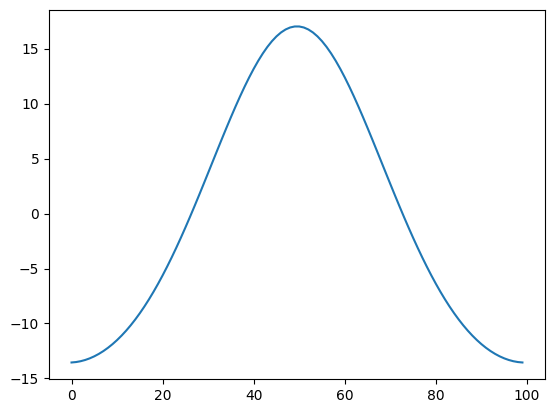

In [97]:
plt.plot(np.imag(_E_zero)) 

On écrit une fonction solve_poisson qui résout automatiquement l'équation de Poisson à $f$ donnée 

In [141]:
def solve_poisson(nx, f):
    c = np.fft.fft2(f) 
    c_tilde = np.zeros(nx, dtype=complex)
    c_tilde[0] = 1 - c[0,0] 
    for i in range(1, nx):
        c_tilde[i] = - c[i,0]        
    d = np.zeros(nx, dtype=complex)
    d[0] = 0 
    for k in range(1,nx):  
        d[k] = (c_tilde[k]) / (k*1j)
    _E = np.fft.ifft(d) 
    return _E 

In [143]:
# Check for coherence 
not np.any(solve_poisson(nx, f_zero) != _E_zero)

True

In [144]:
E = solve_poisson(nx, f_zero) 

100


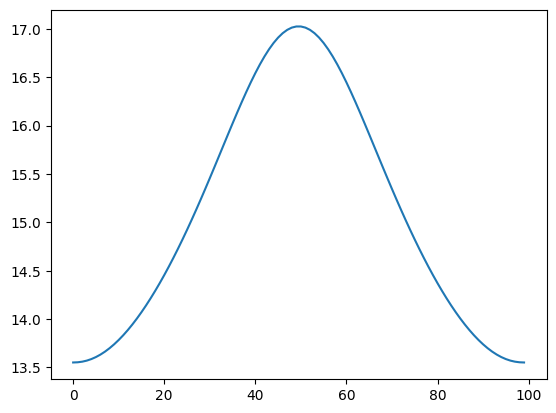

In [145]:
print(len(E))
plt.plot(np.abs(E))

## Transport dans l'équation de Vlasov


L'équation de Vlasov peut être décomposée en deux phénomènes décrivant son évolution :
- une advection en v causée par le champ $E$ : 

\begin{equation}
\tag{a}
\partial_t f - E(x,t) \, \partial_v f = 0 
\end{equation}

- une advection en x causée par le champ de vitesses : 

\begin{equation}
\tag{b}
\partial_t + v \,\partial_x f = 0
\end{equation}

Ces équations sont des équations de transport, dont les solutions analytiques peuvent être obtenues en appliquant la "méthode des caractéristiques".


### Méthode des caractéristiques



On considère une équation de transport 1D homogène à une dimension avec champ de vitesse $a(x,t)$: 

\begin{equation}
\tag{T}
\partial_t u + a(x,t)\,\partial_x u = 0
\end{equation}

Soit $(t,x) \in \mathbb{R}^{+} \times \mathbb{R}$ et  $X(s;t,x), s\in \mathbb{R}$ une courbe paramétrée telle que $X(t;t,x) = x$.

On effectue le calcul de $\frac{d}{ds}u(X(s;t,x), t)$. 

\begin{align*} 
    \frac{\text{d}}{\text{d}s}u(X(s;t,x), s) = \partial_t u(X(s;t,x), s) + \frac{\text{d}X}{\text{d}s}(s;t,x)\, \partial_x u(X(s;t,x),s) & \quad \text{ (règle de la chaine)} 
\end{align*} 

On voit donc avec $(\text{T})$ que cette égalité se réduit à zéro si on impose la condition 

\begin{equation}
\tag{C}
\frac{\text{d}X}{\text{d}s} (s; t,x) = a(X(s;t,x),s) 
\end{equation}

On a ainsi réduit la résolution de l'EDP $(\text{T})$ à la résolution de l'EDO $(\text{C})$ dite "équation des caractéristiques". 


Dans le cas simple où le champ de vitesses $a$ est constant, l'équation $(\text{C})$ s'intégre en 
$$X(s;t,x) = as + b$$ 

et le coefficient b est déterminé par la condition

$$X(t;t,x) = x \implies b = x - at$$ 

de sorte que 

$$X(s;t,x) = x + a(s-t).$$

L'intérêt d'imposer l'équation des caractéristiques $\text{(C)}$ est de fixer 

$$\frac{\text{d}}{\text{d}s}u(X(s;t,x), s)= 0$$

et ainsi $\textbf{la solution est constante le long des courbes caractéristiques}$ de sorte que pour tout $(x,t)$

$$u(x,t) = u(X(t;t,x), t) = u(X(0;t,x), 0) = u_0(x-at)$$ 

où $u_0(x) = u(x, t=0)$ est la condition initiale. 



On voit ainsi ques les équations $(a)$ et $(b)$ sont analytiquement résolues par 

\begin{equation}
\tag{a*}
    f(x,v,t) = f_0(x, v + E(x)t)
\end{equation}
et
\begin{equation}
\tag{b*}
    f(x,v,t) = f_0(x - vt, v)
\end{equation}
respectivement. 

Seulement dans notre cas où l'on cherche à résoudre l'équation de Vlasov-Poisson (où l'évolution du champ électrique $E$ est couplée à l'équation de Vlasov) nous faison face à deux difficultés : 

1) Quel champ $E$ utiliser dans l'étape d'advection en $v$ ? Celui-ci évolue en effet simultanément par rapport à $f$. Cette question va nous amener à définir un schéma de $\textbf{splitting}$.
2) Les points $x-vt$ ou $v + E(x)t$ n'ont aucune raison particulière d'appartenir au maillage $\mathcal{M}$. Ce qui va nous amener à définir une étape $\textbf{d'interpolation}$ dans le schéma. 

## Interpolation en Splines Cubiques

L'interpolation en splines cubiques consiste à approcher une fonction dont on connaît les valeurs en certains points par des polynômes de degré 3 par morceaux d'une manière lisse : en imposant l'égalité des dérivées aux niveaux des "noeuds" c'est-à-dire des points de l'interpolation. 

In [102]:
from scipy.interpolate import CubicSpline

In [103]:
size = 10
# Knots for the spline 
x1 = np.linspace(0,10,size) 
y1 = np.sin(x1)

cs=CubicSpline(x1,y1)

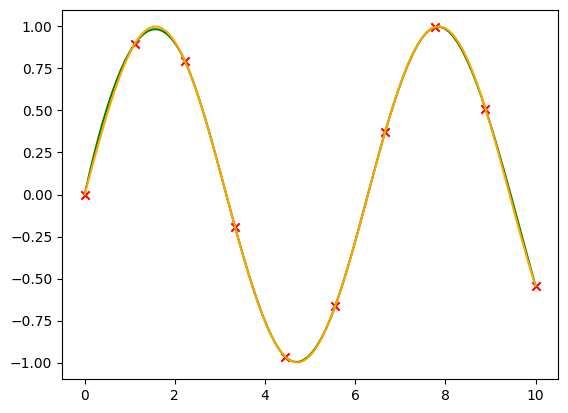

In [104]:
xs = np.linspace(0,10,size*10)

fig, ax = plt.subplots() 
ax.scatter(x1,y1, c='red', marker='x')
ax.plot(xs, cs(xs), c='green')
ax.plot(xs, np.sin(xs), c='orange')
plt.show()

In [131]:
def cubic_spline_interpol_x(x, f, j):
    f_values = f[:,j] 
    spl = CubicSpline(x, f_values) # bc_type='periodic')
    return spl

def build_x_interpolators(x, f):
    x_interpolators = [cubic_spline_interpol_x(x, f, j) for j in range(nv)] 
    return x_interpolators

def cubic_spline_interpol_v(v, f, i):
    f_values = f[i,:] 
    spl = CubicSpline(v, f_values) # bc_type='periodic')
    return spl

def build_v_interpolators(v, f):
    v_interpolators = [cubic_spline_interpol_v(v, f, i) for i in range(nx)]
    return v_interpolators


## Code pour l'advection 

In [132]:
def local_x_advection(x, v, f, i, j, time_step, interpolators):
    _x = x[i]; _v = v[j] 
    return interpolators[j](_x - _v*time_step) 

def local_v_advection(x, v, f, i, j, time_step, _E, interpolators):
    _x = x[i]; _v = v[j] 
    return interpolators[i](_v + _E[i]*time_step) 

def x_advection(x, v, f, time_step):
    x_interpolators = build_x_interpolators(x, f)
    new_f = [local_x_advection(x, v, f, i, j, time_step, x_interpolators) for i,j in np.ndindex((nx,nv))]
    new_f = np.array(new_f)
    new_f.resize((nx,nv)) 
    return new_f 

def v_advection(x, v, f, time_step, _E):
    v_interpolators = build_v_interpolators(v, f) 
    new_f = [local_v_advection(x, v, f, i, j, time_step, _E, v_interpolators) for i,j in np.ndindex((nx,nv))]
    new_f = np.array(new_f)
    new_f.resize((nx, nv))
    return new_f

In [133]:
f_one  = x_advection(x, v, f_zero, dt) 
f_two = v_advection(x, v, f_zero, 0.5*dt, _E_zero) 

/home/murloc/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:946: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.ascontiguousarray(x.ravel(), dtype=np.float_)


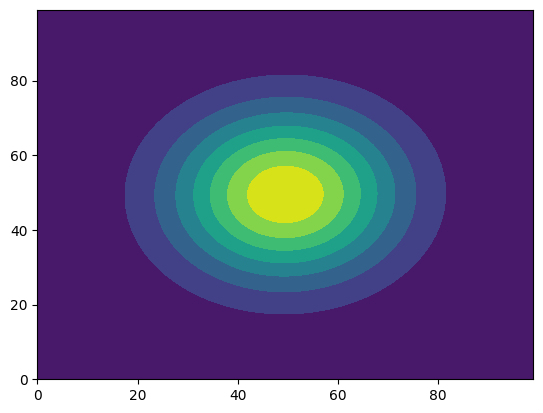

In [134]:
plt.contourf(f_one) 

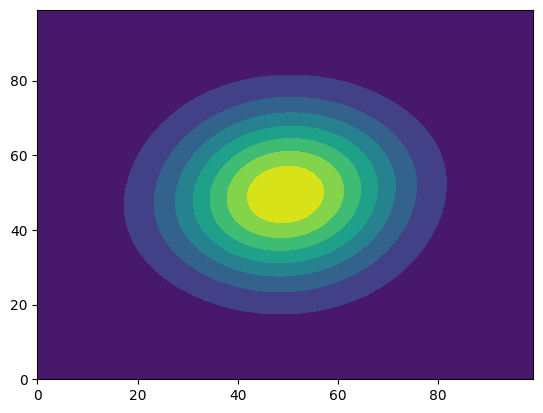

In [135]:
plt.contourf(f_two) 


## Interpolation du champ électrique

In [110]:
# Pas nécessaire a priori dans le schéma, on garde E^n à chaque étape

def build_E_interpolator(_E):
    return CubicSpline(x, _E) 

def _E_advection(_E, j, time_step, interpolator):
    _v = v[j] 
    new_E = np.array([interpolator(x[i] - _v*time_step) for i in range(nx)])
    return new_E 

## Codage de l'intégralité du schéma 

Les différentes étapes sont définies pour définir le schéma dans son intégralité. 

In [138]:
def semi_lagrangian_scheme(x, v, f_zero, n_steps):
    solution = [f_zero] 
    _E_zero = solve_poisson(f_zero) 
    _E = _E_zero
    f = f_zero 
    for i in range(n_steps): 
        f_star = v_advection(x, v, f, 0.5*dt, _E) 
        f_star_two = x_advection(x, v, f_star, dt) 
        new_E = solve_poisson(nx, f_star_two) 
        new_f = v_advection(x, v, f_star_two, 0.5*dt, new_E)
    _E = new_E 
    f = new_f 
    solution.append(new_f) 
    return solution

In [139]:
sol = semi_lagrangian_scheme(f_zero, 100) 

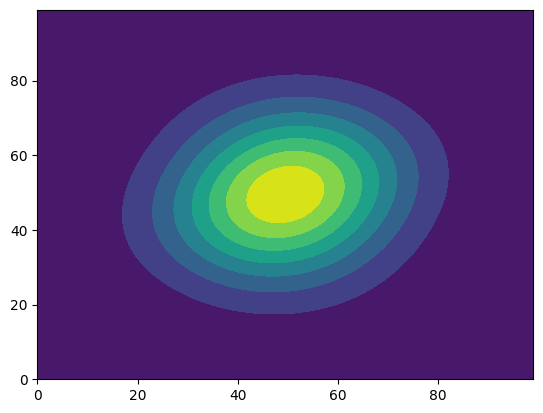

In [140]:
plt.contourf(sol[-1])

## Version du code en programmation objet 

In [146]:
class semi_lagrangian_solver():

    def __init__(self, nx, nv, dt):
        self.dt = dt 
        self.nx = nx 
        self.nv = nv
        self.x = np.linspace(-np.pi, np.pi, nx)
        self.v = np.linspace(-np.pi, np.pi, nv)  
        self._E = None 
        self.f = None 
        self.solutions = [] 
    
    def initialisation(self, f_zero):
        _E_zero = solve_poisson(self.nx, f_zero) 
        self.solutions.append(f_zero) 
        self._E = _E_zero 
        self.f = f_zero 
    
    def solve(self, n_steps):  
        for i in range(n_steps):
            f_star = v_advection(self.x, self.v, self.f, 0.5*self.dt, self._E)
            f_star_two = x_advection(self.x, self.v, f_star, self.dt) 
            new_E = solve_poisson(self.nx, f_star_two)
            new_f = v_advection(self.x, self.v, f_star_two, 0.5*self.dt, new_E) 
            self.f = new_f 
            self._E = new_E
            self.solutions.append(new_f) 



In [147]:
solver = semi_lagrangian_solver(100, 100, dt) 
print(dx, dv, dt) 

TypeError: semi_lagrangian_solver.__init__() missing 2 required positional arguments: 'nv' and 'dt'

In [124]:
solver.initialisation(f_zero)

In [125]:
solver.solve(n_steps=100) 

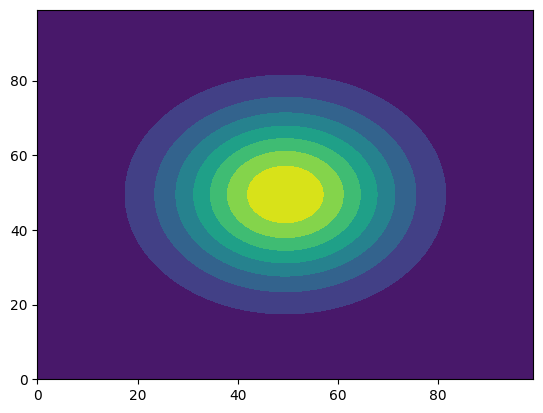

In [126]:
plt.contourf(f_zero)

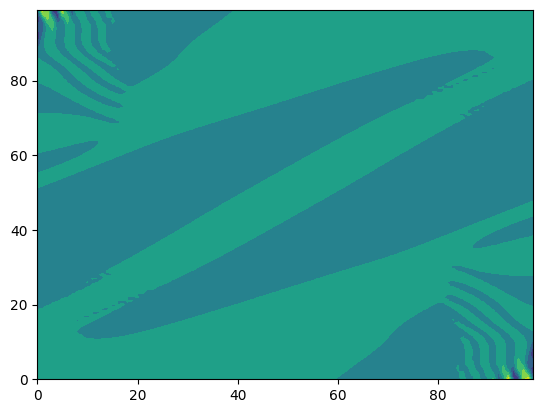

In [127]:
plt.contourf(solver.solutions[-1])